### This is the part #2 of the Homework 6

We did not get a perfect result with the enlarged image, possibly because of enlarged image being too blured. I will continue with the tests. 

In [71]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bc3f05cd00>)

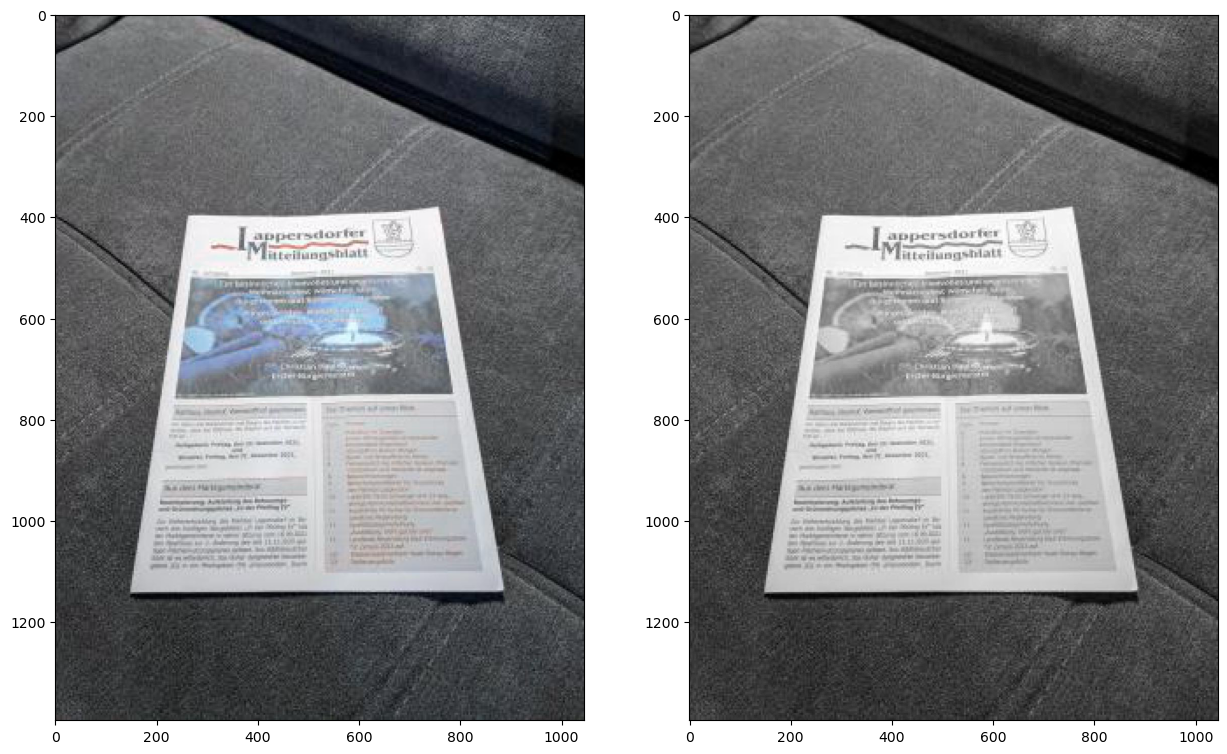

In [72]:
# Let's read the image
img = cv2.imread('document_12mpx.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

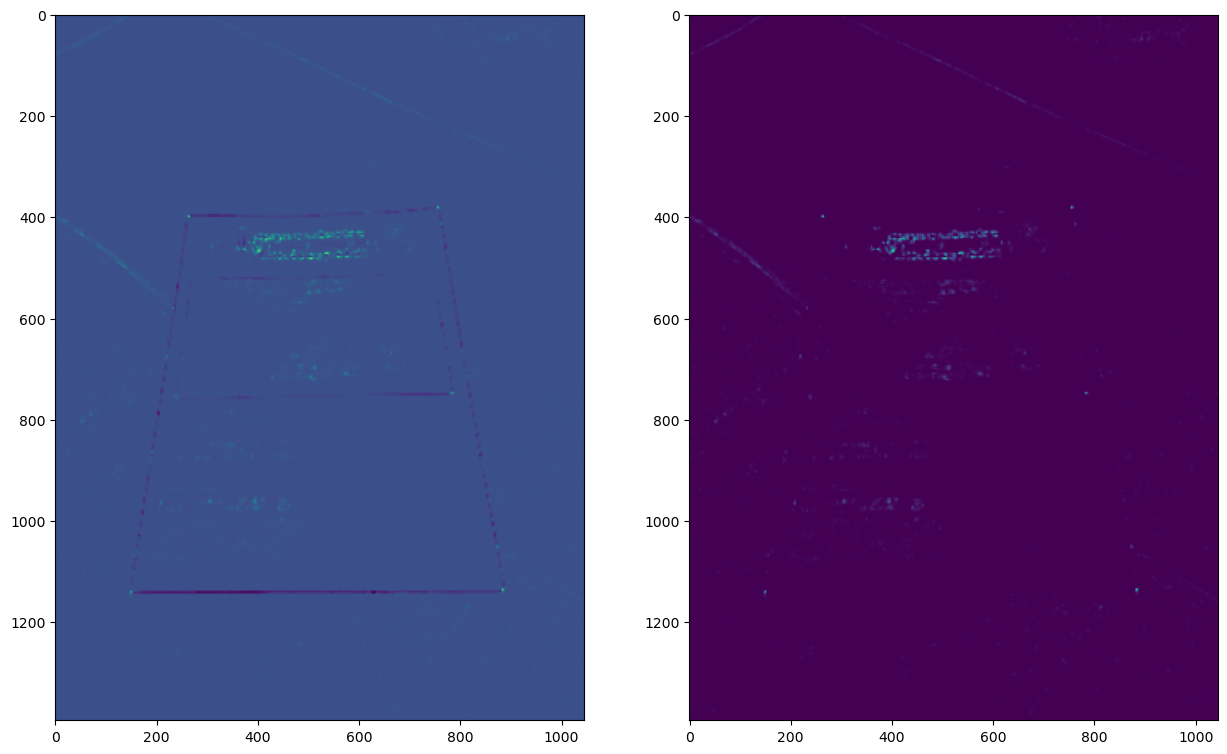

In [73]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04

from asyncio import threads


src = gray.astype(np.float32)
cornerness = cv2.cornerHarris(src, blockSize=7, ksize=3, k=0.04)
plt.subplot(121), plt.imshow(cornerness)   


rows, cols = cornerness.shape
th_edges = 0.3 * np.max(cornerness)
#th_edges = 0
th_corners = 0.3 * np.max(cornerness)
result = np.copy(img)

for r in range(rows):
    for c in range(cols):
        if cornerness[r, c] < -th_edges:
            result = cv2.circle(result, (c,r), 2, (255,0,0), -1)          #show edges in red for better visualization
        if cornerness[r, c] > th_corners:
            result = cv2.circle(result, (c,r), 2, (0,255,0), -1)          #show corners in green for better visualization

# We are not interested in edges, so put to zero all negative cornerness values
#cornerness = cornerness.clip(min=0)
cornerness[cornerness < 0]= 0

plt.subplot(122), plt.imshow(cornerness)  

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)



(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bc419ad490>)

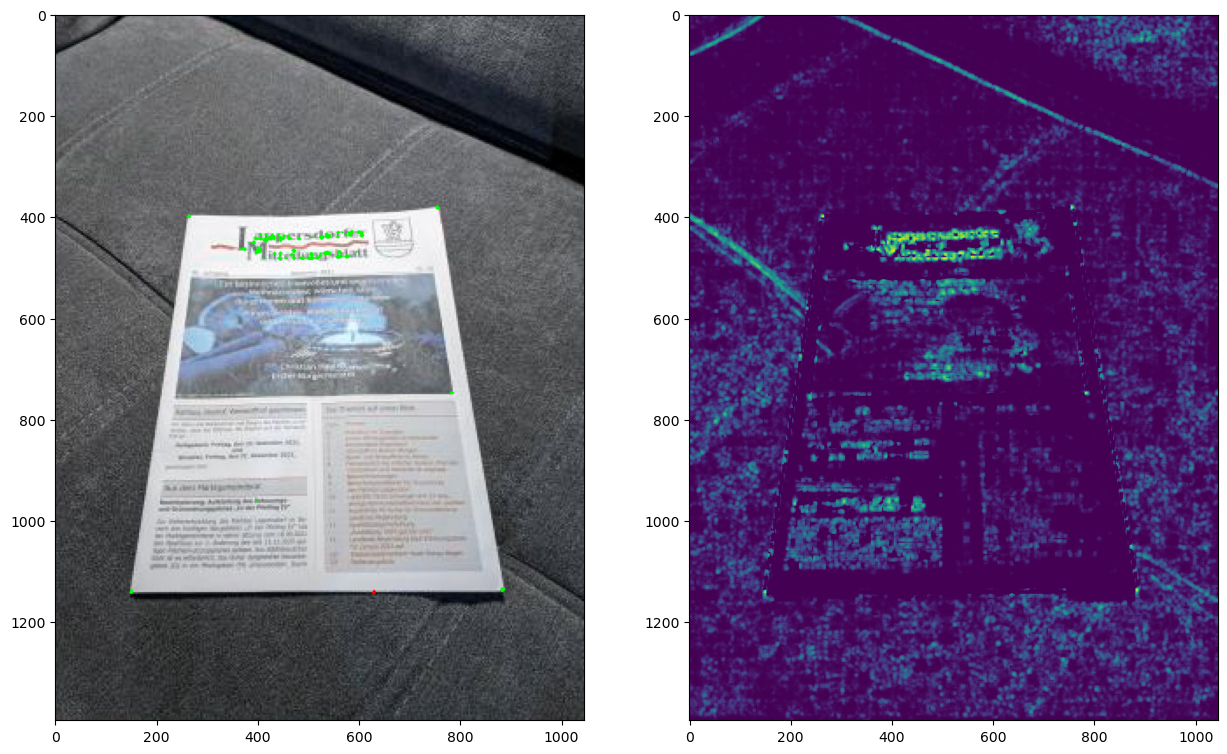

In [74]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(result)
plt.subplot(122), plt.imshow(cornerness)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bc41a49220>)

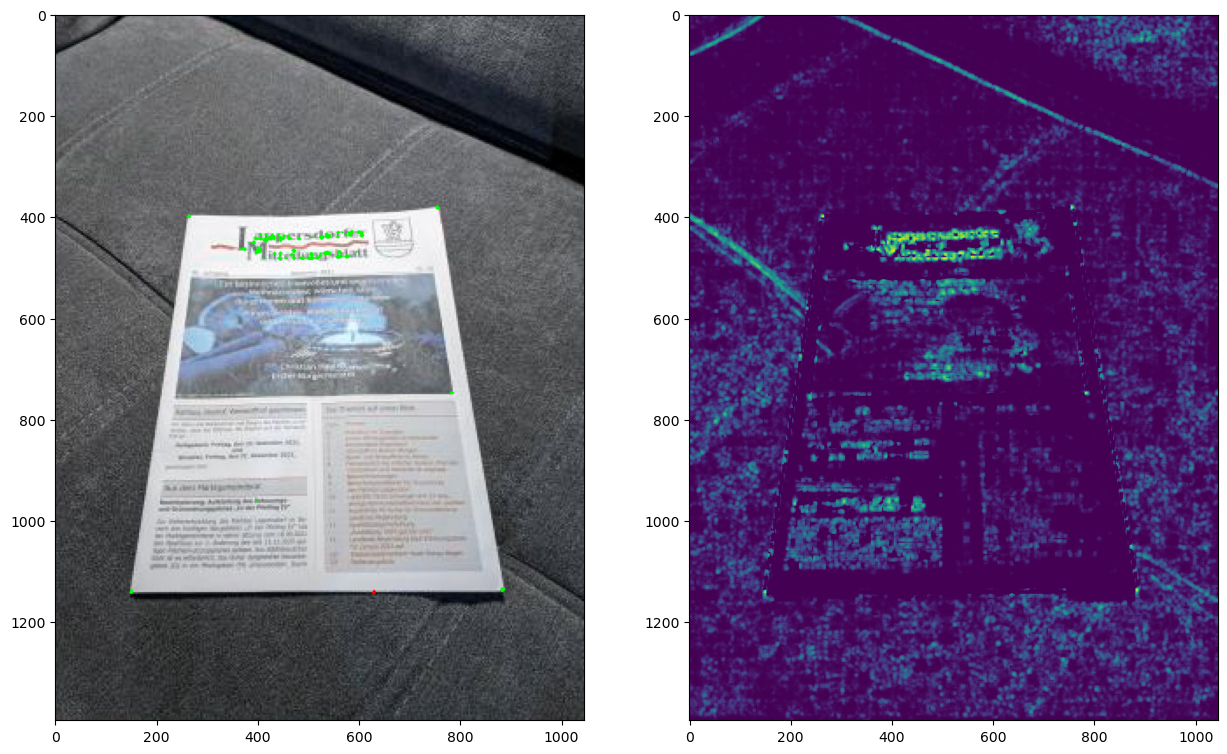

In [75]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(result)
plt.subplot(122), plt.imshow(cornerness)

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.

![Top-left corner](../data/document_descriptor_example.jpg "Top-left corner")

A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1bc428e19a0>)

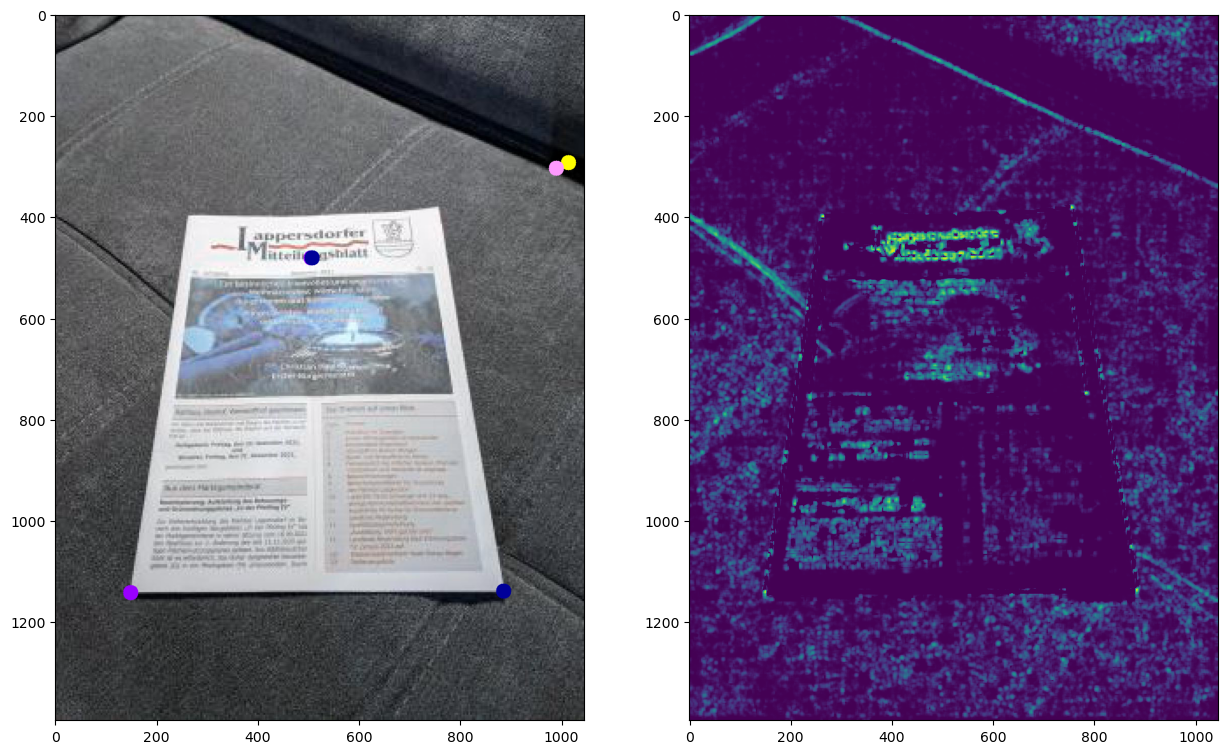

In [78]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 24

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        #if cornerness[r, c] < -7:
        #    continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size:quad_size*2+1]
        quad_bottom_left = block[quad_size:quad_size*2+1, 0:quad_size]
        quad_bottom_right = block[quad_size:quad_size*2+1, quad_size:quad_size*2+1]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            #print(descriptor); print(th_top_left)
            # And we update the optimal location
            opt_top_left = (c, r)

          # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_top_right:
            # We update the threshold
            th_top_right = descriptor
            # And we update the optimal location
            opt_top_right = (c, r)

           
        # Bottom-left corner
          # Top-right corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_bottom_left:
            # We update the threshold
            th_bottom_left = descriptor
            # And we update the optimal location
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_bottom_right:
            # We update the threshold
            th_bottom_right = descriptor
            # And we update the optimal location
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 15, (255,255,0), -1)
out = cv2.circle(img, opt_top_right, 15, (255,153,255), -1)
out = cv2.circle(img, opt_bottom_left, 15, (153,0,255), -1)
out = cv2.circle(img, opt_bottom_right, 15, (0,0,153), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

### This is the part #2 of the Homework6

We did not get a perfect result with the enlarged image, possibly because of enlarged image being too blured. I will continue with the tests. 